<a href="https://colab.research.google.com/github/Ahmadar91/ML/blob/main/Lab_4_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
%matplotlib inline

In [2]:
%pip install matplotlib 
%pip install pandas 
%pip install torch 
%pip install torchvision


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import numpy as np

Define a couple of parameters "meaningfully" -> consult the tutorial for help
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

We want to use the MNIST dataset (not CIFAR)!


In [27]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5

Now we need to load the MNIST dataset using the dataloader functions
for CIFAR the following transforms are used:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

It turns out that for MNIST this transform works better due to the difference in value range:
torchvision.transforms.Compose([
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize(
(0.1307,), (0.3081,))
])

Observe that the RGB image for CIFAR needs three channels (all 0.5) MNIST has only one gray channel!


In [33]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=False
)

I recommend testing is the dataloader worked, render one of the images and put the numeral in the title


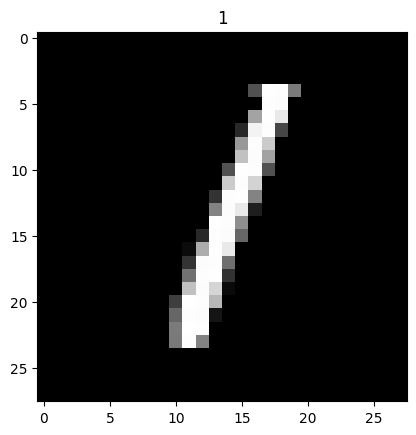

In [29]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

image = image * 0.5 + 0.5

image = image.numpy()

plt.imshow(image.squeeze(), cmap="gray")

plt.title(str(label.item()))

plt.show()

Now we need to define our convolutional neural network, is should have 1 convolutional layer (I recommend handing over the kernel size as a parameter at construction) and 1 pooling layer followed by other normal layers

You only have one in channel (gray)

the number of out channels is up to you - pick wisely, the same applies to the other weights of the other layers


In [30]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        print("kernel size", self.kernel_size)
        input_size = 28
        output_channels_value = 3
        print("output_channels_value", output_channels_value)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=output_channels_value,
            kernel_size=self.kernel_size,
        )
        self.pool = nn.MaxPool2d(self.kernel_size)
        conv_out_size = (input_size - self.kernel_size) + 1
        print(f"conv_out_size: {conv_out_size}")
        pool_out_size = ((conv_out_size - self.kernel_size) // self.kernel_size) + 1
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = (
            output_channels_value * pool_out_size * pool_out_size
        )
        print("input_size_after_conv_and_pool", input_size_after_conv_and_pool)
        self.fc1 = nn.Linear(input_size_after_conv_and_pool, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.features = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

Now implement the training and testing code. Toggle the training and testing for the convolutional neural network
using the model.train() and model.eval() functions!
Choose your own optimiser and loss function!

Collect training and testing accuracy over training


In [38]:
trainAccuracy = list()
testAccuracy = list()

model = MyCNN(5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


def train(model, train_loader, criterion, optimizer):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    return train_accuracy


def test(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy


for epoch in range(n_epochs):
    train_accuracy = train(model, train_loader, criterion, optimizer)
    trainAccuracy.append(train_accuracy)

    test_accuracy = test(model, test_loader)
    testAccuracy.append(test_accuracy)

    print(
        f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
    )

print("Finished Training")

kernel size 5
output_channels_value 3
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 48
Epoch 1, Train Accuracy: 75.49%, Test Accuracy: 92.65%
Epoch 2, Train Accuracy: 93.00%, Test Accuracy: 94.83%
Epoch 3, Train Accuracy: 94.13%, Test Accuracy: 95.40%
Epoch 4, Train Accuracy: 94.70%, Test Accuracy: 95.49%
Epoch 5, Train Accuracy: 95.08%, Test Accuracy: 95.85%
Finished Training


now we plot both to test for overfitting


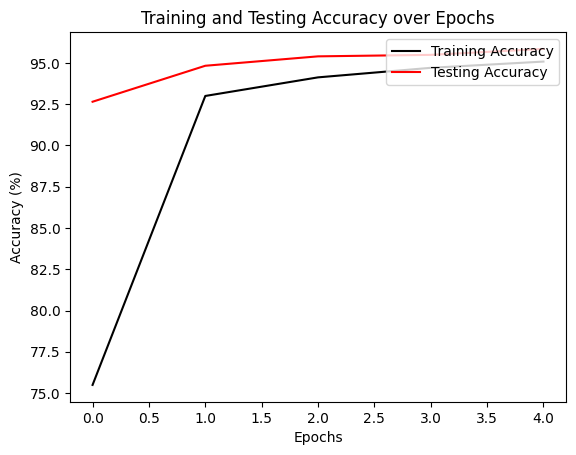

In [39]:
plt.plot(trainAccuracy, "k", label="Training Accuracy")
plt.plot(testAccuracy, "r", label="Testing Accuracy")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper right")

plt.show()

Tune the parameters above until you get a good training efficiency and not too much overfitting, also do not train more than neccesary

In the next cell we define the kernel sizes we want to test


kernel size 2
output_channels_value 3
conv_out_size: 27
pool_out_size: 13
input_size_after_conv_and_pool 507
Epoch 1, Train Accuracy: 85.87%, Test Accuracy: 92.85%
Epoch 2, Train Accuracy: 93.33%, Test Accuracy: 94.43%
Epoch 3, Train Accuracy: 94.79%, Test Accuracy: 95.29%
Epoch 4, Train Accuracy: 95.65%, Test Accuracy: 95.76%
Epoch 5, Train Accuracy: 96.28%, Test Accuracy: 96.29%
Finished Training


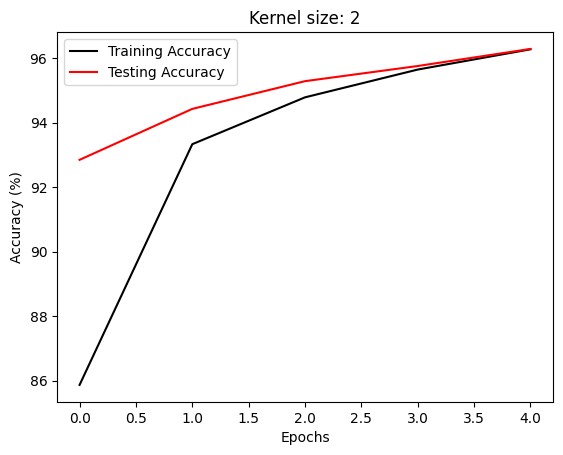

kernel size 3
output_channels_value 3
conv_out_size: 26
pool_out_size: 8
input_size_after_conv_and_pool 192
Epoch 1, Train Accuracy: 82.50%, Test Accuracy: 92.08%
Epoch 2, Train Accuracy: 93.39%, Test Accuracy: 94.77%
Epoch 3, Train Accuracy: 94.85%, Test Accuracy: 95.82%
Epoch 4, Train Accuracy: 95.55%, Test Accuracy: 96.33%
Epoch 5, Train Accuracy: 96.02%, Test Accuracy: 96.56%
Finished Training


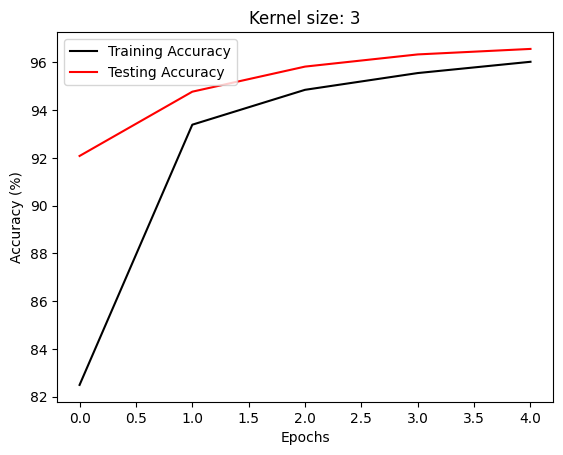

kernel size 4
output_channels_value 3
conv_out_size: 25
pool_out_size: 6
input_size_after_conv_and_pool 108
Epoch 1, Train Accuracy: 81.03%, Test Accuracy: 92.13%
Epoch 2, Train Accuracy: 92.88%, Test Accuracy: 94.66%
Epoch 3, Train Accuracy: 94.50%, Test Accuracy: 95.68%
Epoch 4, Train Accuracy: 95.26%, Test Accuracy: 96.07%
Epoch 5, Train Accuracy: 95.86%, Test Accuracy: 96.38%
Finished Training


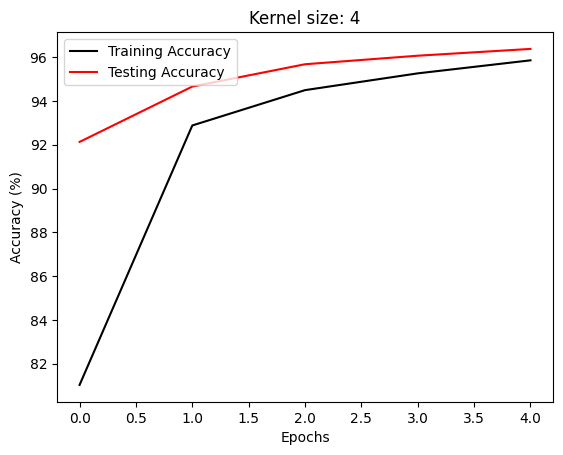

kernel size 5
output_channels_value 3
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 48
Epoch 1, Train Accuracy: 83.09%, Test Accuracy: 93.13%
Epoch 2, Train Accuracy: 93.77%, Test Accuracy: 95.11%
Epoch 3, Train Accuracy: 94.72%, Test Accuracy: 95.60%
Epoch 4, Train Accuracy: 95.22%, Test Accuracy: 95.46%
Epoch 5, Train Accuracy: 95.47%, Test Accuracy: 95.54%
Finished Training


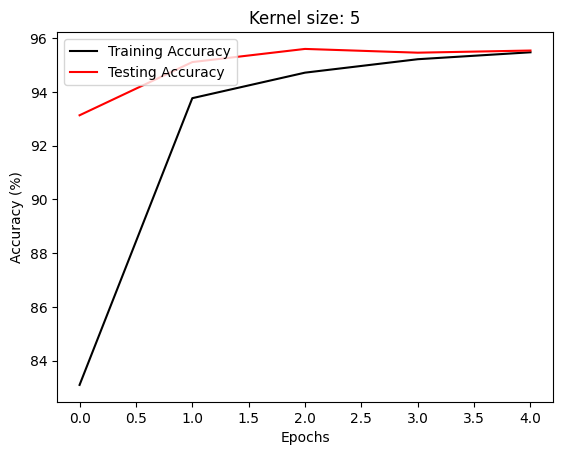

In [43]:
kernelSizes = [2, 3, 4, 5]

for kernelSize in kernelSizes:
    trainAccuracy = list()
    testAccuracy = list()

    model = MyCNN(kernelSize)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        train_accuracy = train(model, train_loader, criterion, optimizer)
        trainAccuracy.append(train_accuracy)

        test_accuracy = test(model, test_loader)
        testAccuracy.append(test_accuracy)

        print(
            f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
        )

    print("Finished Training")
    plt.plot(trainAccuracy, "k", label="Training Accuracy")
    plt.plot(testAccuracy, "r", label="Testing Accuracy")
    plt.title("Kernel size: " + str(kernelSize))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="upper left")
    plt.show()

Compare the plots from above and explain which kernel size worked best, hypothesize about why?



**Observations**:

- **Kernel Size 2** seems to provide a good balance between training and testing accuracy.
- **Kernel Size 3** achieves the highest test accuracy.
- As the kernel size increases, the input size after convolution and pooling decreases significantly. This means that there's a lot of downsampling happening as the kernel size grows, which can lead to loss of information.

**Which kernel size worked best?**  
Kernel size 3 achieved the highest test accuracy. It provides a good balance by capturing more localized features than kernel size 2 but without too aggressive downsampling as seen in kernel sizes 4 and 5.

**Hypotheses**:

1. **Localized Features**: A kernel size of 2 or 3 is smaller and might be capturing more localized features in the images, which are crucial for digit recognition. As the kernel size increases, the convolutional layer might be looking at broader features, which might not be as discriminative for MNIST digits.

2. **Downsampling and Information Loss**: With increasing kernel size, the spatial dimensions reduce more aggressively, especially after pooling. For instance, with a kernel size of 5, the feature map is pooled down to a size of 4x4, which could lead to significant information loss. 

3. **Complexity and Overfitting**: A larger kernel has more parameters and could potentially overfit to the training data. However, since the test accuracies are still high, it doesn't seem to be a significant issue in this case.

4. **Dataset Specificity**: MNIST is a dataset with relatively simple patterns. Larger kernels might be more suitable for datasets with complex and varied textures or patterns.

Now pick a random image and pipe it through your trained CNN
extract the output of the convolutional layer for each output channel and visualize that as an image
Observe that the template CNN has a self.features variable ... that might help here


In [49]:
kernel_values = model.conv1.weight.detach().numpy()
print("Kernel Values:")
print(kernel_values)
print(model)

Kernel Values:
[[[[-0.10145728 -0.07771835 -0.1088145   0.22883335  0.57903486]
   [-0.29333803 -0.17831728 -0.2805172   0.27817425  0.33756006]
   [-0.31929192 -0.02512414  0.04812261  0.38288188  0.45639765]
   [-0.39142668 -0.02269295  0.40259013  0.2035639   0.25274464]
   [ 0.32056016  0.5779496   0.41499266  0.19296181  0.18163161]]]


 [[[ 0.3206588   0.5098289   0.2046246  -0.12995142 -0.66117936]
   [ 0.26606488  0.47927943  0.31938484  0.11641291 -0.326724  ]
   [-0.16402276  0.3259779   0.3851695   0.29232702 -0.01873844]
   [-0.21614663  0.17355387  0.430051    0.4807256   0.41949242]
   [-0.04580257 -0.14114861  0.04517493  0.3691942   0.5464703 ]]]


 [[[ 0.18957509  0.38487703  0.261021    0.023172    0.32128018]
   [ 0.14753623  0.3317492   0.5131234   0.51439816  0.55014956]
   [-0.42395496  0.09975535  0.29157668  0.13051523  0.00137972]
   [-0.60320526 -0.61350936 -0.36804283 -0.36774236 -0.46932107]
   [-0.14372815 -0.36832833 -0.5935388  -0.3803545  -0.2961693 ]]]]

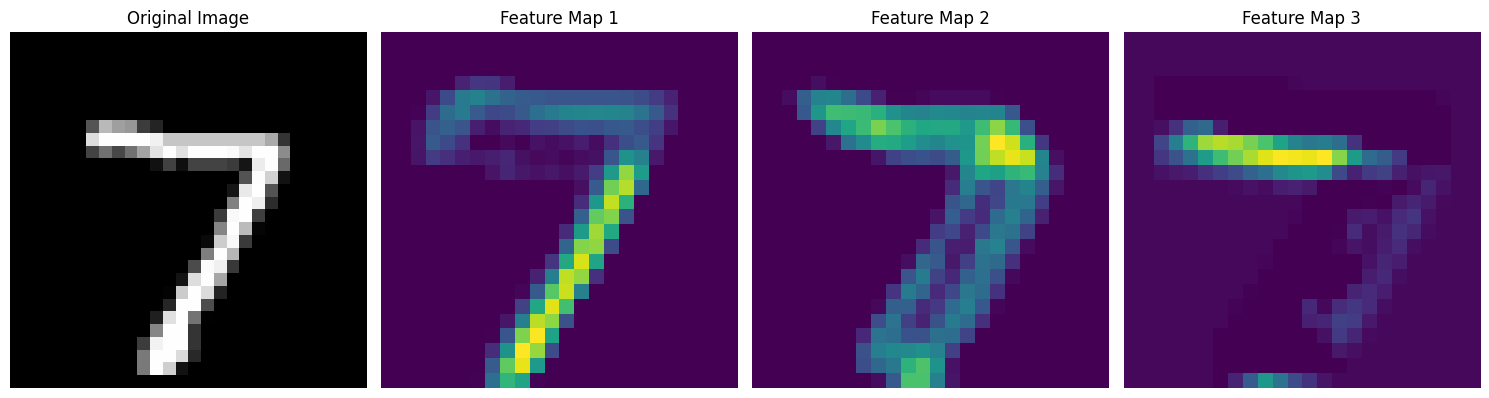

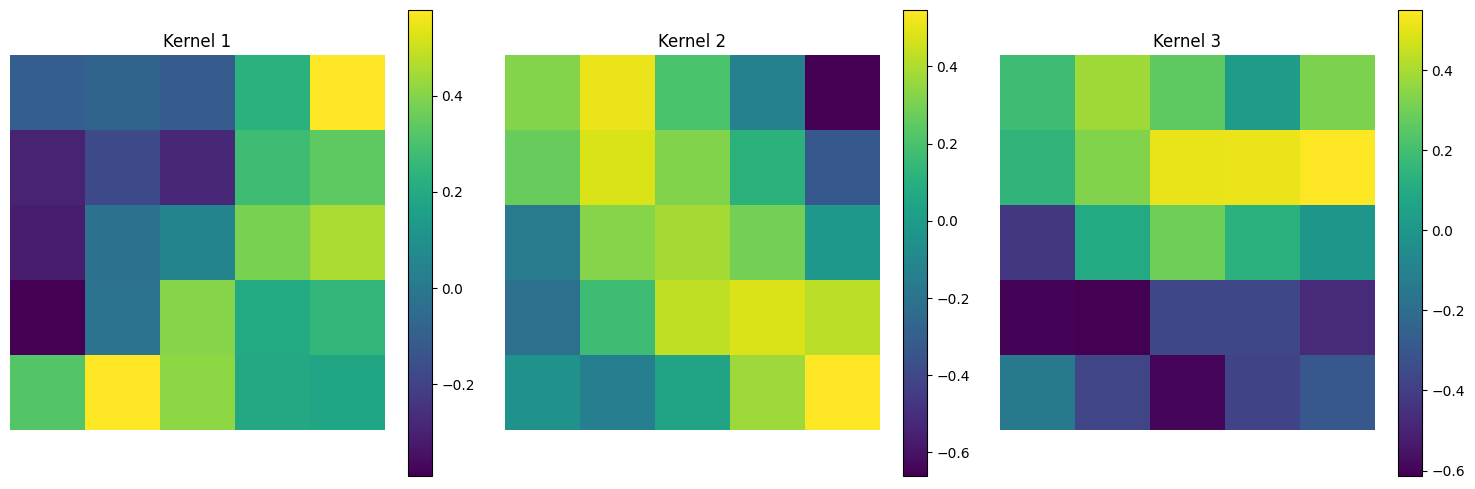

In [54]:
model.eval()  

image, label = next(iter(test_loader))

input_image = image[0].unsqueeze(0)

output = model(input_image)

feature_maps = model.features.squeeze(0).detach().numpy()

kernel_values = model.conv1.weight.detach().numpy()

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(input_image.squeeze(0).squeeze(0), cmap="gray")
plt.title("Original Image")
plt.axis('off')

for i in range(3):  
    plt.subplot(1, 4, i+2)
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i in range(3):  
    plt.subplot(1, 3, i+1)
    plt.imshow(kernel_values[i, 0], cmap="viridis")  
    plt.title(f"Kernel {i+1}")
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()


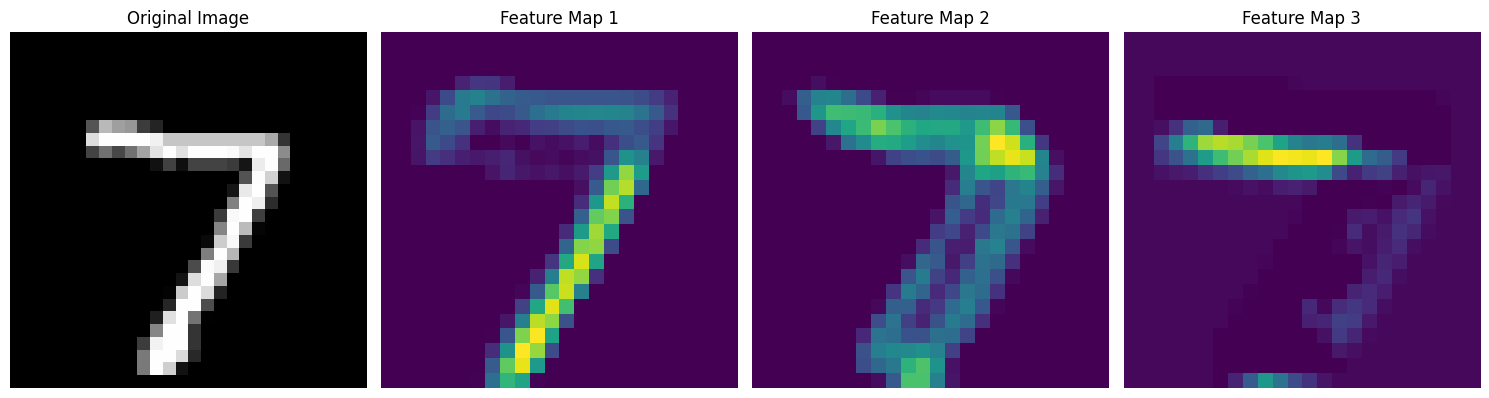

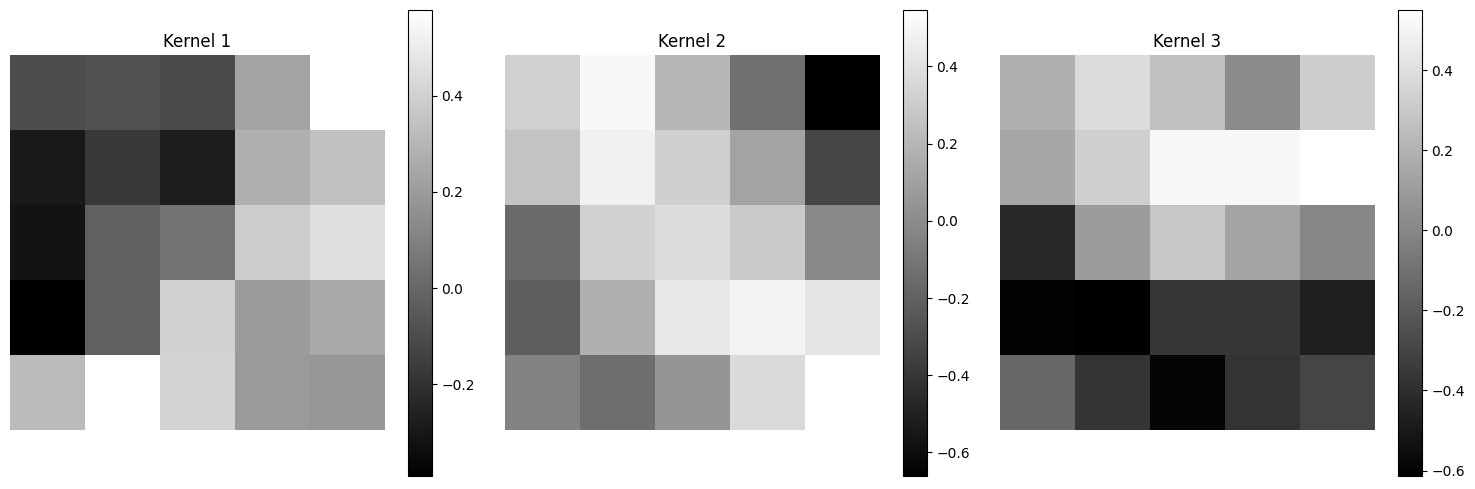

In [55]:
model.eval()  

image, label = next(iter(test_loader))

input_image = image[0].unsqueeze(0)

output = model(input_image)

feature_maps = model.features.squeeze(0).detach().numpy()

kernel_values = model.conv1.weight.detach().numpy()

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(input_image.squeeze(0).squeeze(0), cmap="gray")
plt.title("Original Image")
plt.axis('off')

for i in range(3):  
    plt.subplot(1, 4, i+2)
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i in range(3):  
    plt.subplot(1, 3, i+1)
    plt.imshow(kernel_values[i, 0], cmap="gray")  
    plt.title(f"Kernel {i+1}")
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()


Can you guess the feature that each channel extracted? short text below

Your answer here:

1. **Kernel 1 (Negative values prevalent)**:

   - The kernel has predominantly negative values, especially in its top-left and bottom-left corners. This means it will respond to the opposite of those values.
   - It might be detecting top-right or bottom-right oriented edges or bright patterns in those areas of the image.

2. **Kernel 2 (Positive values prevalent)**:

   - This kernel has positive values, especially in its top and bottom-left corners.
   - High activations from this kernel might indicate the presence of top-left or bottom-left oriented edges or patterns in the image.

3. **Kernel 3 (Combination of Positive and Negative values)**:
   - The kernel has a combination of positive values on the right and negative values on the left.
   - This suggests that it might be sensitive to vertical edges, especially those transitioning from dark to light from left to right.

- The digit '7' typically has a horizontal edge on the top and a diagonal edge going from top-left to bottom-right.
- Given the kernels:
  - **Kernel 1** might activate on the horizontal edge of the '7' due to its sensitivity to bright patterns or edges in the top-right or bottom-right.
  - **Kernel 2** might not have a strong activation for '7' since '7' lacks dominant features in the top-left or bottom-left corners. However, if it does activate, it might be due to the top horizontal edge.
  - **Kernel 3** could possibly activate on the diagonal part of '7' since it's sensitive to vertical edges.






  Based on the provided kernel values and the feature maps, I can provide a general interpretation:

1. **Kernel 1**:
   - The kernel values for this channel seem to have a pattern where the top-right section has positive (lighter) values, while the bottom-left section has negative (darker) values. 
   - This suggests that this kernel might be sensitive to edges or transitions from dark to light (or vice versa) in the top-right to bottom-left direction.
   - If the feature map for this kernel highlights certain regions of the image, it's likely those regions contain the aforementioned type of edge or gradient.

2. **Kernel 2**:
   - The kernel values here show a central region with positive values surrounded by negative values.
   - This might mean that the kernel is looking for regions in the image that are brighter in the center and darker on the outside, potentially capturing circular or center-bright patterns.
   - The feature map for this kernel would likely activate on such patterns.

3. **Kernel 3**:
   - The values in this kernel seem to emphasize the top and bottom regions with a dark center.
   - This kernel might be capturing horizontal edges or transitions where the center is darker than the top and bottom.
   - The feature map for this kernel would activate on horizontal edges or transitions.

In practice, the meaning and role of each kernel in a CNN, especially in deeper layers, can become abstract and harder to interpret directly. The above interpretations are basic and based on a visual inspection of the kernel values. In real-world scenarios, especially with more complex datasets and deeper networks, understanding the exact function of each kernel requires more in-depth analysis and sometimes even remains a topic of research.
